In [8]:
"""
import necessary modules
"""
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
import util

"""
parameters
"""
robot_ip_address = "192.168.254.87" # robot ip address
output_config_pick = [0, 0, 0] # output in order (pin, off state, on state)
output_config = {
    "decap": [1, 1, 0],
    "pick": [0, 1, 0],
    "barcode": [0, 1, 1],
    "decap_place": [0, 1, 0],
}
tcp = {
    "5ml_cap": [0, 0, 53, 0, 0, 90],
    "15ml_cap":[0, 0, 43, 0, 0, 90],
    "50ml_cap": [0, 0, 53, 0, 0, 90],
}

decap_round = {
    "5ml_cap": 8,
    "15ml_cap": 8,
    "50ml_cap": 6,
}

imaging_joint = [90.175781, 79.958496, -108.325195, 0.219727, -67.456055, 0.087891]

middle_joint = imaging_joint
# decap
place_position = {
    "5ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
    "15ml_cap":[136.730417, 278.806365, 140, 127, -127, 0],
    "50ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
}

# decap
decap_position = {
    "5ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
    "15ml_cap":[136.730417, 278.806365, 140, 127, -127, 0],
    "50ml_cap": [161.921621, 278.731741, 140, 127, -127, 0],
}

cap_drop_joint = [0, 45, -128, 10, -4, 0]
barcode_pose = [323.088207, 293.246132, 140, 127, -127, 0]

speed_pick = 0.5 # here set the speed of the robot
speed_place = 0.2
above = 130
motion = "lmove"
sim=0
# detection parameters
detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0,0, 0, 0, 0, 0, 0],
        #"T": [46.5174596+1+1, 32.0776662-3+1-0, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
        "T": [46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516]
    },
    'detection': {'cmd': 'od', 'path': 'tube.pkl', 'conf': 0.5, 'cls': []}, 
    'limit': {'area': [0, 100000], 'aspect_ratio': [0.9, 1.0], 'xyz': [[-140, 110], [200, 420], [110, 140]], 'inv': 0}, 
    'output': {'max_det': 20, 'shuffle': True, 'save_img': True, 'save_img_roi': False}
    }

#filter = {"spatial":[5, 0.5, 20], "temporal":[0.2, 100], "hole_filling":1}
filter = None

# pick
rvec_base = [180, 0, 0]
padding = 5 # pixel
gripper_opening = 50 #mm

In [3]:
"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera = Camera() # initialize camera
camera.connect(filter=filter) # connect to camera

detection = Detection(camera=camera, robot=robot, **detection_parameters) # initialize the object detection

"""
set up the robot
"""
robot.set_output(output_config["pick"][0], output_config["pick"][2]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving
robot.jmove(imaging_joint)  #set safe initial position

"""
run the object detection and pick and place
"""
for i in range(1):  # range is set to 5 because we have 5 chips
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.1)

    s = time.time()
    # run the object detection
    result = detection.run()
    img_1 = detection.img.copy()
    
    # pick_pose
    for r in result:
        r["tcp"] = tcp[r["cls"]]
    
    # best pick
    best_pick_result = util.best_pick(result, rvec_base, detection.camera_data["joint"], robot, detection.frame_mat_inv, camera.camera_matrix(detection.camera_data["depth_int"]), camera.dist_coeffs(detection.camera_data["depth_int"]), padding, gripper_opening)
    print("best_pick: ", best_pick_result)
    if best_pick_result is not None:
        pick_pose, label, start, end, pose_valid_list, pose_not_valid_list = best_pick_result
        
        # tcp
        robot.kinematic.set_tcp_xyzabc(tcp[label])

        # second detection
        second_img_pose = list(pick_pose)
        second_img_pose[2] += above/2
        second_img_pose[1] += -30
        second_img_joint = robot.kinematic.inv(second_img_pose, detection.camera_data["joint"], False)[0]
        second_img_joint[5] = 0

        # go above
        print("go_second: ", pick_pose, second_img_pose, second_img_joint)
        print(robot.jmove(second_img_joint[0:6]))
        
        # run the object detection
        time.sleep(0.1)
        result = detection.run()
        print("run: ", time.time()-s)
        for r in result:
            if np.linalg.norm(np.array(r["xyz"]) - np.array(pick_pose[0:3])) < 10:
                pick_pose[0:3] = r["xyz"]
                # this executes the pick-and-place operation
                retval_pick = robot.pick_n_place(
                    pick_pose=pick_pose, # pick position we got from detection
                    place_pose=barcode_pose, # place poistion which we got from the class
                    middle_joint = middle_joint,
                    #end_joint=imaging_joint, # end position which we will call the imaging postion because after ending  we want to scan again
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["barcode"], # output in order (pin, off state, on state)
                    above=above,
                    motion=motion,
                    sim=sim,
                    )
                break        



robot.close() # close robot
camera.close() # close camera
detection.close() # close object detection

best_pick:  ([25.45175796263588, 337.32246391267677, 121.13561480917969, 176.54135047258148, -35.11625796290309, 0.0], '15ml_cap', (814, 266), (686, 211), [[[25.45175796263588, 337.32246391267677, 121.13561480917969, 180.0, 0.0, 0.0], (820, 239), (680, 238)], [[25.45175796263588, 337.32246391267677, 121.13561480917969, 176.54135047258148, -35.11625796290309, 0.0], (814, 266), (686, 211)], [[25.45175796263588, 337.32246391267677, 121.13561480917969, 166.2983158520316, -68.88301782571615, 0.0], (799, 289), (702, 188)], [[25.45175796263588, 337.32246391267677, 121.13561480917969, 149.66453021445815, -100.00264194352839, 0.0], (776, 304), (725, 172)], [[25.45175796263588, 337.32246391267677, 121.13561480917969, 127.27922061357856, -127.27922061357854, 0.0], (749, 309), (752, 167)], [[25.45175796263588, 337.32246391267677, 121.13561480917969, 100.00264194352842, -149.66453021445815, 1.341104507446289e-06], (722, 303), (779, 173)], [[25.45175796263588, 337.32246391267677, 121.13561480917969,

In [21]:
x  = robot.kinematic.inv(second_img_pose, detection.camera_data["joint"], False)[0]
robot.kinematic.fw(x)

[-48.48254064835813,
 262.44984712997723,
 276.3757546136065,
 174.13260366582537,
 0.1903123943047075,
 -0.2848226260230061]

In [23]:
print(detection.camera_data["joint"])
print(second_img_joint)
print(second_img_pose)
print(tcp[label])



[90.219727, 80.002441, -108.369141, 0.219727, -67.5, 0.0, 0.0, 0.0]
[  90.219727   80.002441 -108.369141    0.219727  -67.5         0.
    0.          0.      ]
[-30.600205621228746, 321.768564937482, 187.14261114268052, 180.0, 0.0, 0.0]
[0, 0, 43, 0, 0, 90]


In [36]:
robot.connect(robot_ip_address)
robot.jmove(imaging_joint)
robot.jmove(second_img_joint)
robot.go(second_img_pose, tcp=tcp[label], motion="lmove", sim=sim)

robot.close()

True

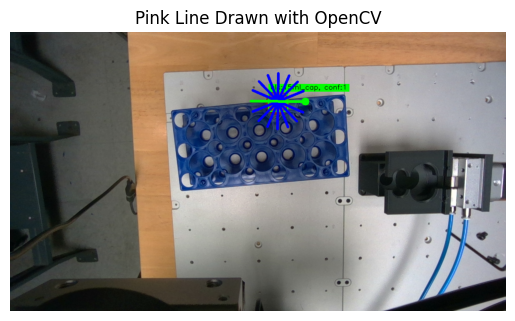

In [41]:
# try_1:  [343.5424054361505, -208.54841173866896, 120.96906205162398]

# "x":345.550535,"y":-208.05732,"z":164.920105
import matplotlib.pyplot as plt
import cv2 as cv

# draw start end
img = img_1.copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = 5

# good
for p in pose_valid_list:
    cv.line(img, p[1], p[2], (255, 0, 0), thickness)



# bad
for p in pose_not_valid_list:
    cv.line(img, p[1], p[2], (0, 0, 255), thickness)

# best
cv.line(img, start, end, (0, 255, 0), thickness)
cv.circle(img, start, 10, (0, 255, 0), -1)


# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()

In [80]:
import json
for r in retval_pick:
    print(json.dumps(r))

{"cmd": "lmove", "rel": 0, "j0": -41.09167437499832, "j1": 43.96787678964545, "j2": -58.98856511363226, "j3": -1.7053025658242404e-13, "j4": -74.9793116760132, "j5": -86.09167437499826, "vel": 100.0, "accel": 400.0, "jerk": 800.0, "cont": 0}
{"cmd": "lmove", "rel": 0, "j0": -41.09167437499832, "j1": 24.805352872099313, "j2": -67.05507857906593, "j3": -3.751665644813329e-12, "j4": -47.750274293033385, "j5": -86.09167437499582}
{"cmd": "output", "out0": 0, "queue": 0}
{"cmd": "sleep", "time": 0.5}
{"cmd": "lmove", "rel": 0, "j0": -41.09167437499832, "j1": 43.96787678964545, "j2": -58.98856511363226, "j3": -1.7053025658242404e-13, "j4": -74.9793116760132, "j5": -86.09167437499826, "vel": 40.0, "accel": 160.0, "jerk": 200.0, "cont": 1, "corner": 100}
{"cmd": "lmove", "rel": 0, "j0": -18.87314952074513, "j1": 82.17766904160504, "j2": -113.14492519168994, "j3": 0.0, "j4": -59.03274384991511, "j5": -108.8731495207451, "cont": 0}
{"cmd": "lmove", "rel": 0, "j0": -19.08257603149724, "j1": 48.88

In [ ]:
"""barcode reading"""
robot = Dorna()
robot.connect(robot_ip_address)
util.barcode_read(robot)
robot.close()

True

In [ ]:
"""decap place"""
robot = Dorna()
robot.connect(robot_ip_address)

robot.pick_n_place(
    pick_pose=None, # pick position we got from detection
    place_pose=decap_position[label], # place poistion which we got from the class
    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
    speed=speed_pick, # speed which we also defined in the cfg cell
    output_config = output_config["decap_place"], # output in order (pin, off state, on state)
    above=above,
    motion=motion,
    sim=sim,
    )



robot.close()

In [58]:
t = "50ml_cap"
robot = Dorna()
robot.connect(robot_ip_address)
sim = 0
# start
robot.jmove([54.55, 63.85, -104, 0, -50, -34])
robot.set_output(output_config["pick"][0], output_config["pick"][2])
robot.set_output(output_config["pick"][0], output_config["pick"][1]) # set output


# drop
robot.go((np.array(place_position[t])+np.array([0, 0, above, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.go(place_position[t], tcp=tcp[t], motion="lmove", sim=sim)
robot.set_output(output_config["pick"][0], output_config["pick"][2])


# approach
robot.go((np.array(place_position[t])+np.array([0, 0, -23, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)

#hold
robot.set_output(output_config["decap"][0], output_config["decap"][1]) # set output
for i in range(7):
    robot.set_output(output_config["pick"][0], output_config["pick"][1]) # close
    robot.lmove(rel=1, z=1.1, a=-307.278746,b=-127.253498, vel=500, accel=4000, jerk=10000) # rotate
    #dehold
    robot.set_output(output_config["pick"][0], output_config["pick"][2]) # open
    robot.jmove(rel=1, j5=90, vel=200, accel=2000, jerk=6000) # rotate


# grab the cap
#robot.go((np.array(place_position[t])+np.array([0, 0, -15, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.set_output(output_config["pick"][0], output_config["pick"][1]) # close
robot.go((np.array(place_position[t])+np.array([0, 0, 20, 0, 0, 0])).tolist(), tcp=tcp[t], motion="jmove", sim=sim)
robot.jmove(cap_drop_joint)
robot.set_output(output_config["pick"][0], output_config["pick"][2]) # open
robot.set_output(output_config["decap"][0], output_config["decap"][2]) # open


robot.close()



True